In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/Ml/nbs/dl2/


from exp.nb_04 import *

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


def get_data():
    import os
    import torchvision.datasets as datasets
    root = '../data'
    if not os.path.exists(root):
        os.mkdir(root)
    train_set = datasets.MNIST(root=root, train=True, download=True)
    test_set = datasets.MNIST(root=root, train=False, download=True)
    x_train, x_valid = train_set.data.split([50000, 10000])
    y_train, y_valid = train_set.targets.split([50000, 10000])
    return (x_train.view(50000, -1) / 256.0), y_train.float(), (x_valid.view(10000, -1))/ 256.0, y_valid.float()


Mounted at /content/gdrive
/content/gdrive/MyDrive/Ml/nbs/dl2


## Initial setup

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
# loss_func = F.cross_entropy original
loss_func = torch.nn.CrossEntropyLoss()
torch.__version__

'1.8.1+cu101'

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
from torch import optim
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1] #size of input

    # model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c)) original
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,int(data.c)))
    return model, optim.SGD(model.parameters(), lr=lr)

learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)
# self.yb.long() add

train: [0.669437890625, tensor(0.8016)]
valid: [0.29626396484375, tensor(0.9162)]
train: [0.304524296875, tensor(0.9115)]
valid: [0.2585958984375, tensor(0.9252)]
train: [0.2481435546875, tensor(0.9279)]
valid: [0.2148462646484375, tensor(0.9375)]


In [ ]:
learn = create_learner(get_model(lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

In [ ]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

In [ ]:
# what is annealing?

# annealing is a probabilistic technique for approximating the global optimum of a given function. 
# Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem

In [ ]:
# why we do that in training loop especially learning rate?

# there are famous ways to make model efficient such as noam decay - transformers (or warm-up and linear decay)
# 
# because in early training loop, parameters are very sensitive and very unstable
# we need to prevent to get the wrong momentum. To achieve this we have some training part called warm-up
# and many researcher found this kind of reason especially in [Liu et al., 2019] recent paper

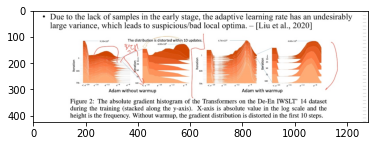

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("sched.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
# https://flonelin.wordpress.com/2019/09/12/radamon-the-variance-of-the-adaptive-learning-rate-and-beyond/

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7202)

In [ ]:
# To do annealing, we will do one exercises, for example  adjusting the learning rate according to epoch or bs.
# we will make learning rate scheduler changing steadily up or down during training process
# We will define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate
# and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

# keep track of the numbers related with loss and lr
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

# it is really unlikely use same parameters for all of our layers
# we can adjust parameters according to training step. for example, sometimes make lower or sometimes make higher
class ParamScheduler(Callback):
    _order=1
                    #lr     # function
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func
                        # parameter name, and scheduler function
    def set_param(self):
        for pg in self.opt.param_groups: # contains number of parameter groups
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
# for example
#optimizer = torch.optim.SGD(
# [
#     {'params': model.Seq[0].parameters(), 'lr': 0.1},
#     {'params': model.Seq[1:3].parameters(), 'lr': 0.01},
#     {'params': model.Seq[4].parameters(), 'lr': 0.001},
# ])

    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7431)

In [ ]:
# pos will be 0 to 1
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

In [ ]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)



# when 2 and 4 given in sched_lin()
# def annealer(sched_lin):
#     def _inner(2, 4): return partial(sched_lin, 2, 4)
#     return _inner

# 

In [ ]:
f = sched_lin(1,2)
f(0.3) # what is lr when in 30% training

1.3

And here are other scheduler functions:

In [ ]:
#remember all positions are between 0~1

# cosine
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
# nothing
@annealer
def sched_no(start, end, pos):  return start
# exponential
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

# up and down(mixed)
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]



## we cannot pytorch tensor to plot directly
#####This monkey-patch method needs to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))


In [ ]:
# what is monkey-patch?
# A monkey patch is a way to change, extend, or modify a library, plugin, or supporting system software locally.

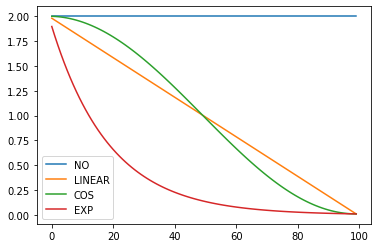

In [ ]:
# so we need to give information about how dimension for plotting to matplotlib
# So we do define ndim which is used for matplotlib
torch.Tensor.ndim = property(lambda x: len(x.shape)) # especially works as setter
# then we can use

annealings = "NO LINEAR COS EXP CYCLE".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

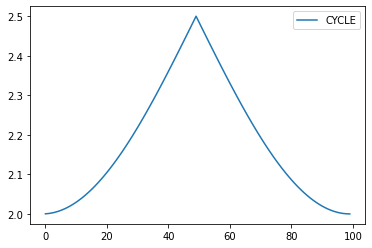

In [ ]:
# i made it.. jeremey doesn't show all..
f = cos_1cycle_anneal(2,3,2)

plt.plot(a, [f[0](o) for o in p[:50]] + [f[1](o) for o in p[50:]], label='CYCLE')
    
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [ ]:
#sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    # print(pcts) # 0,0.3,0.7
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    # print(pcts) # 0, 0.3, 1.0
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max() #nonzero -> get the index of no zeros
        # print(pos,pcts,idx)
        # print((pos >= pcts).nonzero())
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx]) # get the relative position (pos-0) / (0.3) or (pos-0.3) / (0.7)
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) # determine the lr is kind of art.
# phase1 30% phase2 70%
# sched_cos(), sched_cos()

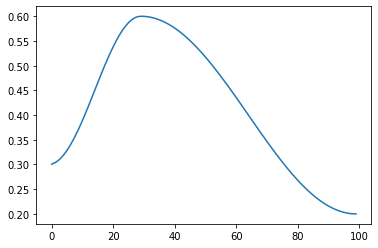

In [ ]:
plt.plot(a, [sched(o) for o in p])
# a = torch.arange(0, 100)
# p = torch.linspace(0.01,1,100)

We can use it for training quite easily...

In [ ]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
run.fit(3, learn)

train: [0.7724390625, tensor(0.7875)]
valid: [0.480773779296875, tensor(0.8587)]
train: [0.29726275390625, tensor(0.9135)]
valid: [0.233673974609375, tensor(0.9338)]
train: [0.23766115234375, tensor(0.9325)]
valid: [0.21063681640625, tensor(0.9400)]


... then check with our recorder if the learning rate followed the right schedule.

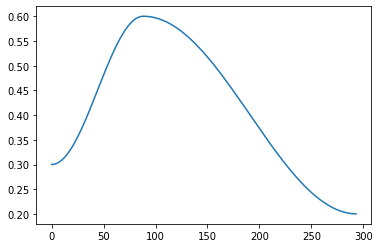

In [ ]:
run.recorder.plot_lr()

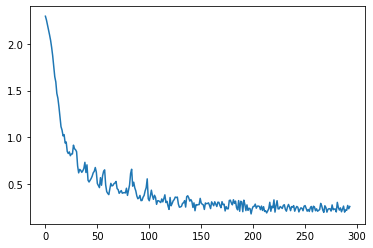

In [ ]:
run.recorder.plot_loss()

In [ ]:
cbfs = [Recorder]
learn = create_learner(get_model_func(0.01), loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(3, learn)

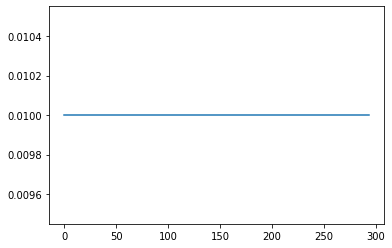

In [ ]:
run.recorder.plot_lr()

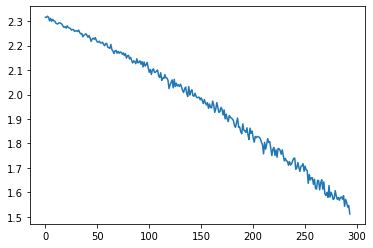

In [ ]:
run.recorder.plot_loss()

## Export

In [ ]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to nb_05.py
